In [1]:
!pip list

Package                      Version
---------------------------- ---------
absl-py                      1.0.0
argon2-cffi                  21.1.0
astunparse                   1.6.3
attrs                        21.2.0
backcall                     0.2.0
bleach                       4.1.0
cachetools                   4.2.4
certifi                      2021.10.8
cffi                         1.15.0
charset-normalizer           2.0.7
click                        8.0.3
colorama                     0.4.4
cycler                       0.11.0
debugpy                      1.5.1
decorator                    5.1.0
defusedxml                   0.7.1
entrypoints                  0.3
flatbuffers                  2.0
gast                         0.4.0
google-auth                  2.3.3
google-auth-oauthlib         0.4.6
google-pasta                 0.2.0
grpcio                       1.41.1
h5py                         3.5.0
idna                         3.3
ipykernel                    6.5.0
ipython    

You should consider upgrading via the 'E:\lambda\labs\ds-test-2\venv2\Scripts\python.exe -m pip install --upgrade pip' command.



ipywidgets                   7.6.5
jedi                         0.18.0
Jinja2                       3.0.3
jsonschema                   4.2.1
jupyter                      1.0.0
jupyter-client               7.0.6
jupyter-console              6.4.0
jupyter-core                 4.9.1
jupyterlab-pygments          0.1.2
jupyterlab-widgets           1.0.2
keras                        2.7.0
Keras-Preprocessing          1.1.2
kiwisolver                   1.3.2
libclang                     12.0.0
Markdown                     3.3.4
MarkupSafe                   2.0.1
matplotlib                   3.4.3
matplotlib-inline            0.1.3
mistune                      0.8.4
nbclient                     0.5.8
nbconvert                    6.3.0
nbformat                     5.1.3
nest-asyncio                 1.5.1
notebook                     6.4.5
numpy                        1.21.4
oauthlib                     3.1.1
opencv-python                4.5.4.58
opt-einsum                   3.3.0
packaging    

This notebook was executed on:
- Windows 10
- Ryzen 3900x
- 32 GB ram
- Nvidia 3080

# Research question:
is it possible using the sythetic dataset provided by generate.py and samples of user input provided by story_photo_transformer.py to generate coordinates with less than 8pix mean average error.

---

## Hypothesis
Adding convolution layers to the beginning of the model will improve MAE to below baseline levels

In [2]:
#shared experiment variables
global_batch_size = 96
global_epochs = 1000
global_learning_rate =.00015

# experiment groups
# experiment group Q will test networks that have had their dense layers initialized to constants
group_Q = []
group_Q.append({
    "experiment_label" :"q1",
    "experiment_desc":"constant initialization 1 conv layer, 3 FC Dense of 32 Height",
    "num_conv" :"1",
    "initialization":"constant",
})
group_Q.append({
    "experiment_label" :"q2",
    "experiment_desc":"constant initialization 2 conv layer, 3 FC Dense of 32 Height",
    "num_conv" :"2",
    "initialization":"constant",
})
group_Q.append({
    "experiment_label" :"q3",
    "experiment_desc":"constant initialization 3 conv layer, 3 FC Dense of 32 Height",
    "num_conv" :"3",
    "initialization":"constant",
})
# experiment group R will test networks that have the default random initialization
group_R = []
group_R.append({
    "experiment_label" :"r1",
    "experiment_desc":"default random initialization 1 conv layer, 3 FC Dense of 32 Height",
    "num_conv" :"1",
    "initialization":"default",
})
group_R.append({
    "experiment_label" :"r2",
    "experiment_desc":"default random initialization 2 conv layer, 3 FC Dense of 32 Height",
    "num_conv" :"2",
    "initialization":"default",
})
group_R.append({
    "experiment_label" :"r3",
    "experiment_desc":"default random initialization 3 conv layer, 3 FC Dense of 32 Height",
    "num_conv" :"3",
    "initialization":"default",
})
experiments = group_Q+group_R

In [3]:
# graphing function
def display_history(hist,label):
    # plot history

    loss_p = hist.history['loss']
    val_loss_p = hist.history['val_loss']

    plt.figure(figsize=(15,5))
    plt.plot(loss_p, label='MAE (training data)')
    plt.title(label)
    plt.ylabel('MAE value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    #plt.yscale('log',base=2)
    plt.show()

    plt.figure(figsize=(15,5))
    plt.plot(val_loss_p, label='MAE (validation data)')
    plt.title(label)
    plt.ylabel('MAE value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    #plt.yscale('log',base=2)
    plt.show()

    for i in range(0,len(hist.history['val_loss']),1000):
        min_loss = np.array(hist.history['loss'])[:i+1000].min()
        min_val =  np.array(hist.history['val_loss'])[:i+1000].min()
        print(f'By epoch {i+1000} The minimum MAE achieved by the training was {min_loss}.')
        print(f'By epoch {i+1000} The minimum MAE achieved on the real data was {min_val}.')

In [4]:
## section that handles loading data
import os
os.add_dll_directory(r'e:\cuda\bin')

import json
import time
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import cv2
import glob

# this is the path to the synthetic data generated by generate.py, you may need to change this to match your system.
data_dir =r'..\..\..\models\synthetic_data\synthetic_data_for_pipeline_transform\data\*\*'
example_data_files = glob.glob(data_dir)[0:]
print(f'Example of data {example_data_files[0:3]}, {len(example_data_files)} records')

# load each of the X_input files using opencv and convert to BGR colorspace as required by opencv
X_train =[ cv2.cvtColor(cv2.imread(x),cv2.COLOR_RGB2BGR) for x in example_data_files if "X_input" in x ]
# load point data for each record
y_train =[ json.loads( open(y,'rb').read() )["y_label_points"] for y in example_data_files if ".json" in y ]

# convert lists to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train).reshape((X_train.shape[0],8))

# load real data
# this loads actual recorded user data that optimally we would like to predict with zero error.

path_real = r'..\..\..\data\transcribed_stories\*\*\phase0\*'
real_set=glob.glob(path_real)
# load and convert the data
X_real =np.array([ cv2.cvtColor(cv2.imread(x),cv2.COLOR_RGB2BGR) for x in real_set if "X_input" in x ])
y_real =[ json.loads(open(y,'rb').read() )["y_label_points"] for y in real_set if ".json" in y ]
y_real = np.array(y_real).reshape((X_real.shape[0],8))

assert (X_real.shape[0]==y_real.shape[0])
print(f'Sythetic  data contains {X_train.shape[0]} records.')
print(f'Real data contains {X_real.shape[0]} records.')

Example of data ['..\\..\\..\\models\\synthetic_data\\synthetic_data_for_pipeline_transform\\data\\10\\007880cf-c97e-425d-9577-96318042598d.json', '..\\..\\..\\models\\synthetic_data\\synthetic_data_for_pipeline_transform\\data\\10\\007880cf-c97e-425d-9577-96318042598d.X_input.png', '..\\..\\..\\models\\synthetic_data\\synthetic_data_for_pipeline_transform\\data\\10\\007880cf-c97e-425d-9577-96318042598d.y_label.png'], 22170 records
Sythetic  data contains 7390 records.
Real data contains 3 records.


In [5]:
def create_experiment_model(num_conv,initialization):
    if initialization == "constant":
        c_init = keras.initializers.Constant(.004)
        b_init = keras.initializers.Constant(.004)
    else:
        c_init=None
        b_init=None

    img_inputs = keras.Input(shape=(256, 256-64, 3))
    x = img_inputs

    for _ in range(int(num_conv)):
        x = layers.Conv2D(32,(3,3),(2,2))(x)
        x = tf.keras.layers.ReLU()(x)
        x = layers.MaxPool2D(strides=(2,2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(32, activation="relu",dtype="float32",kernel_initializer=c_init,bias_initializer=b_init)(x)
    x = layers.Dense(32, activation="relu",dtype="float32",kernel_initializer=c_init,bias_initializer=b_init)(x)
    x = layers.Dense(32, activation="relu",dtype="float32",kernel_initializer=c_init,bias_initializer=b_init)(x)

    outputs = layers.Dense(8,activation="relu",kernel_initializer=c_init,bias_initializer=b_init)(x)

    model = keras.Model(inputs=img_inputs, outputs=outputs, name="FC_Model")
    model.summary()
    model.compile(loss="MAE",optimizer=tf.keras.optimizers.Adam(learning_rate=global_learning_rate))
    return model

def run_experiment(model):
    with tf.device("GPU"):
        history = model.fit(X_train,y_train,epochs=global_epochs,validation_data=(X_real,y_real),shuffle=False,verbose=0,
                            batch_size=global_batch_size)

        return history



=== Experiment q1 ===
constant initialization 1 conv layer, 3 FC Dense of 32 Height
Model: "FC_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 192, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 127, 95, 32)       896       
                                                                 
 re_lu (ReLU)                (None, 127, 95, 32)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 47, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 94752)             0         
                                                                 
 dense (Dense)               (None, 32

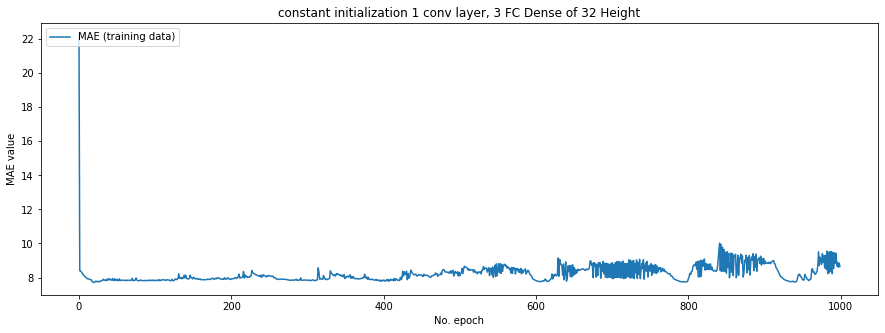

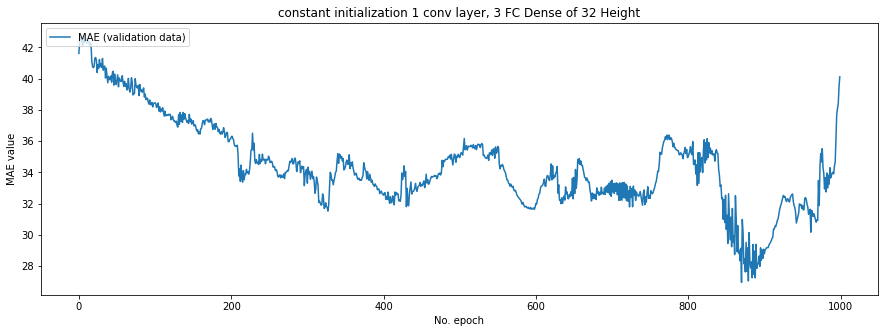

By epoch 1000 The minimum MAE achieved by the training was 7.710071563720703.
By epoch 1000 The minimum MAE achieved on the real data was 26.942642211914062.


=== Experiment q2 ===
constant initialization 2 conv layer, 3 FC Dense of 32 Height
Model: "FC_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 192, 3)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 127, 95, 32)       896       
                                                                 
 re_lu_1 (ReLU)              (None, 127, 95, 32)       0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 63, 47, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (C

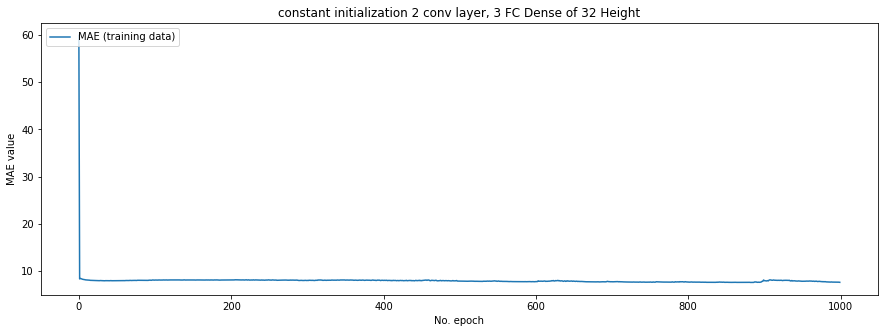

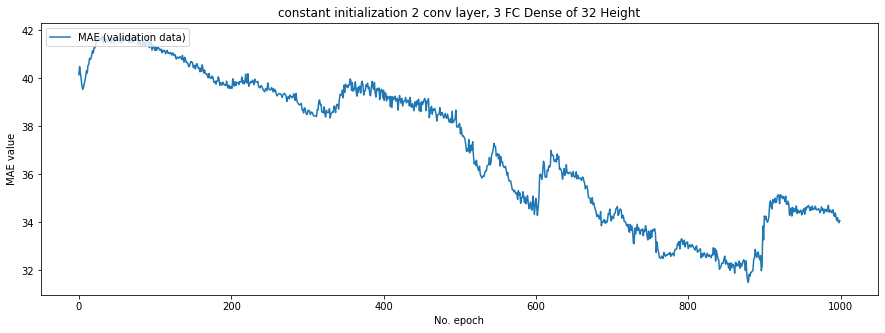

By epoch 1000 The minimum MAE achieved by the training was 7.577856063842773.
By epoch 1000 The minimum MAE achieved on the real data was 31.495946884155273.


=== Experiment q3 ===
constant initialization 3 conv layer, 3 FC Dense of 32 Height
Model: "FC_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 192, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 127, 95, 32)       896       
                                                                 
 re_lu_3 (ReLU)              (None, 127, 95, 32)       0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 47, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (C

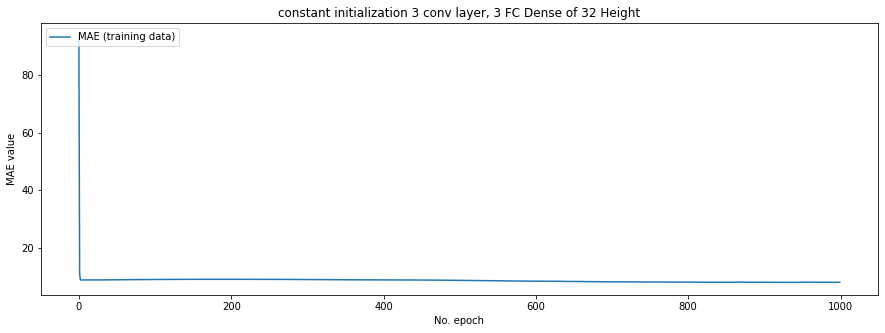

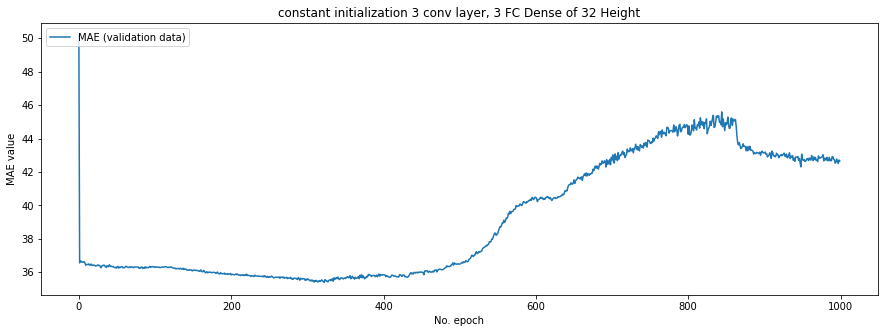

By epoch 1000 The minimum MAE achieved by the training was 7.870067119598389.
By epoch 1000 The minimum MAE achieved on the real data was 35.388858795166016.


=== Experiment r1 ===
default random initialization 1 conv layer, 3 FC Dense of 32 Height
Model: "FC_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 192, 3)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 127, 95, 32)       896       
                                                                 
 re_lu_6 (ReLU)              (None, 127, 95, 32)       0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 63, 47, 32)       0         
 2D)                                                             
                                                                 
 flatt

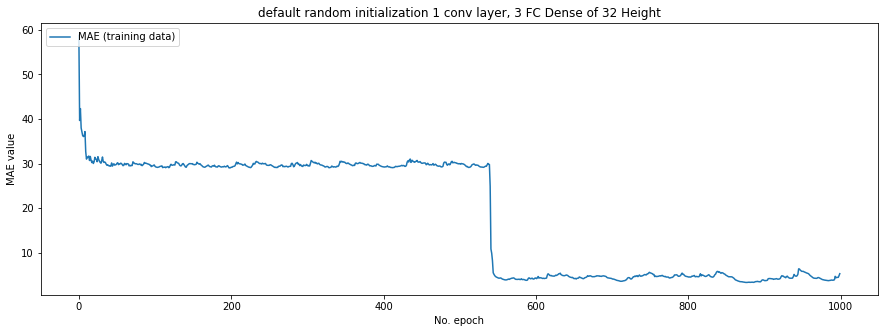

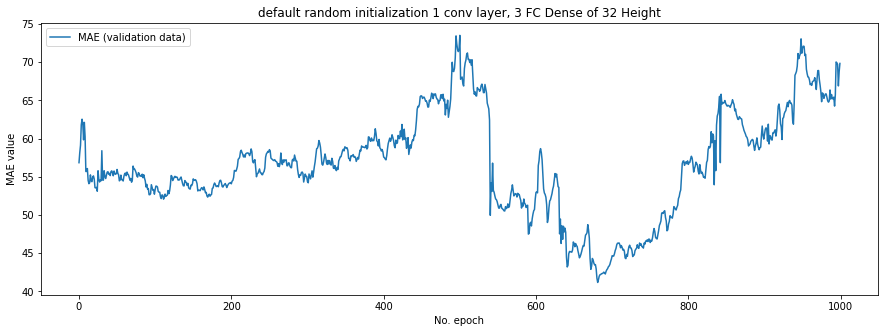

By epoch 1000 The minimum MAE achieved by the training was 3.367377996444702.
By epoch 1000 The minimum MAE achieved on the real data was 41.17236328125.


=== Experiment r2 ===
default random initialization 2 conv layer, 3 FC Dense of 32 Height
Model: "FC_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256, 192, 3)]     0         
                                                                 
 conv2d_7 (Conv2D)           (None, 127, 95, 32)       896       
                                                                 
 re_lu_7 (ReLU)              (None, 127, 95, 32)       0         
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 63, 47, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 

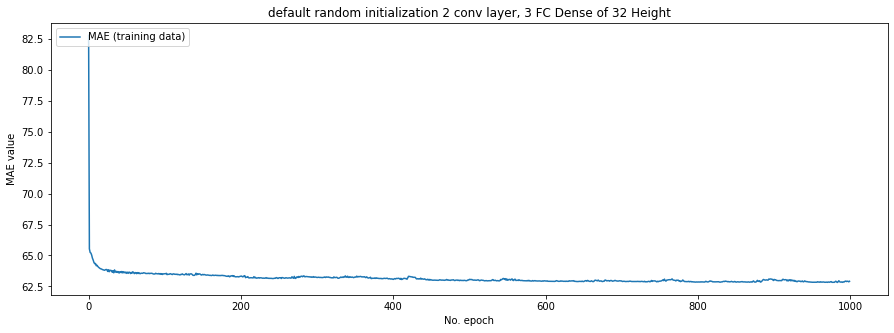

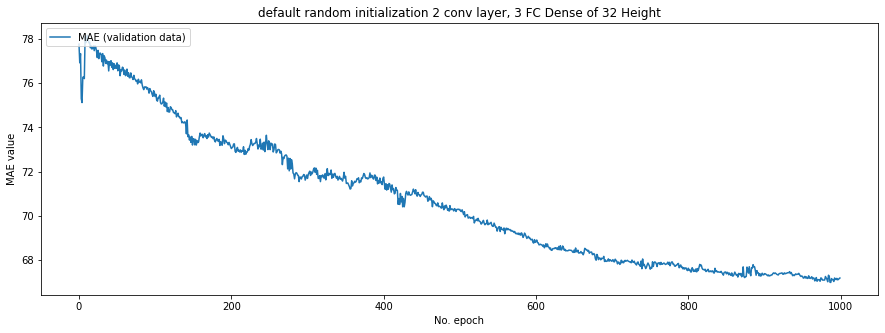

By epoch 1000 The minimum MAE achieved by the training was 62.81932830810547.
By epoch 1000 The minimum MAE achieved on the real data was 66.97464752197266.


=== Experiment r3 ===
default random initialization 3 conv layer, 3 FC Dense of 32 Height
Model: "FC_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 256, 192, 3)]     0         
                                                                 
 conv2d_9 (Conv2D)           (None, 127, 95, 32)       896       
                                                                 
 re_lu_9 (ReLU)              (None, 127, 95, 32)       0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 63, 47, 32)       0         
 2D)                                                             
                                                                 
 conv2d

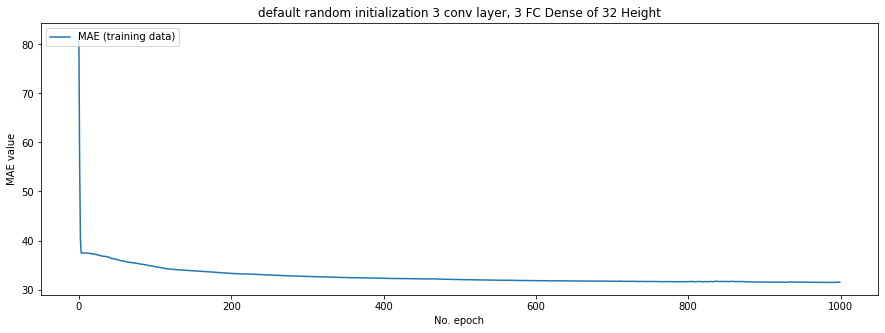

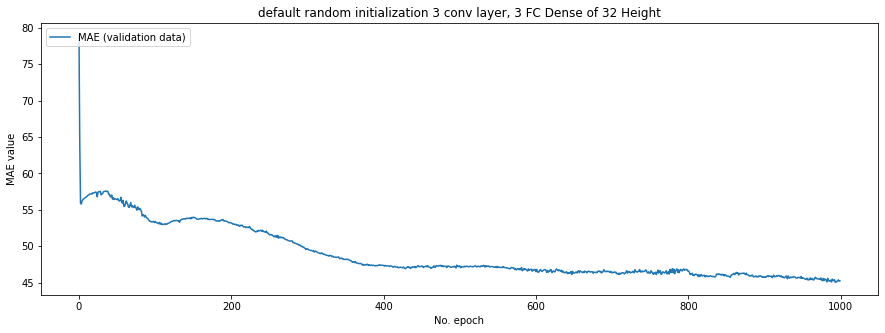

By epoch 1000 The minimum MAE achieved by the training was 31.458845138549805.
By epoch 1000 The minimum MAE achieved on the real data was 45.023773193359375.
number of seconds to run all experiments: 5918.22203040123


In [6]:
start_time = time.time()
results={}
for E in experiments:
    print("\n")
    print( f'=== Experiment {E["experiment_label"]} ===')
    print( E["experiment_desc"])
    model = create_experiment_model(E["num_conv"],E["initialization"])
    history = run_experiment(model)
    display_history(history,E["experiment_desc"])

    results[E["experiment_label"]]={
    "min_val_mae":np.array(history.history["val_loss"]).min()
    }
print (f'number of seconds to run all experiments: {time.time()-start_time}')